In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import shap
%matplotlib inline

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

In [28]:
# Carregar o dataset já limpo
df = pd.read_csv('../data/processed/advertising_cleaned.csv')

print("Dados limpos carregados:")
df.head()

Dados limpos carregados:


,Daily Time Spent on Site,Age,Area Income,Daily Internet Usage,Male,Clicked on Ad,Hour,DayOfWeek,Month
0,68.95,35,61833.90,256.09,0,0,0,6,3
1,80.23,31,68441.85,193.77,1,0,1,0,4
2,69.47,26,59785.94,236.50,0,0,20,6,3
3,74.15,29,54806.18,245.89,1,0,2,6,1
4,68.37,35,73889.99,225.58,0,0,3,4,6


In [29]:
# 1. Definir os passos do Pipeline
# Passo 1: Padronizar os dados (StandardScaler)
# Passo 2: Treinar o modelo de Regressão Logística
pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('logreg', LogisticRegression(solver='lbfgs', max_iter=1000)) # Aumentar max_iter para garantir convergência
])

# 2. Definir o Grid de Parâmetros
# Vamos testar diferentes valores para o parâmetro de regularização 'C'
# O nome do parâmetro no pipeline é 'nomedomodelo__parametro'
param_grid = {
    'logreg__C': [0.001, 0.01, 0.1, 1, 10, 100]
}

# 3. Configurar e Rodar o GridSearchCV
# cv=5 significa 5-Fold Cross-Validation
# scoring='roc_auc' é uma ótima métrica para classificação balanceada
# n_jobs=-1 usa todos os processadores disponíveis para acelerar o processo
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='roc_auc', n_jobs=-1, verbose=1)

# Treinar com os dados de treino
print("Iniciando a busca pelos melhores hiperparâmetros...")
grid_search.fit(X_train, y_train)

# 4. Exibir os melhores resultados
print(f"\nMelhores parâmetros encontrados: {grid_search.best_params_}")
print(f"Melhor score AUC (validação cruzada): {grid_search.best_score_:.4f}")

# 5. Usar o melhor modelo encontrado para as previsões
# O grid_search já retreina o melhor modelo com todos os dados de treino no final
best_model = grid_search.best_estimator_
predictions = best_model.predict(X_test)

Iniciando a busca pelos melhores hiperparâmetros...
Fitting 5 folds for each of 6 candidates, totalling 30 fits

Melhores parâmetros encontrados: {'logreg__C': 0.001}
Melhor score AUC (validação cruzada): 0.9889


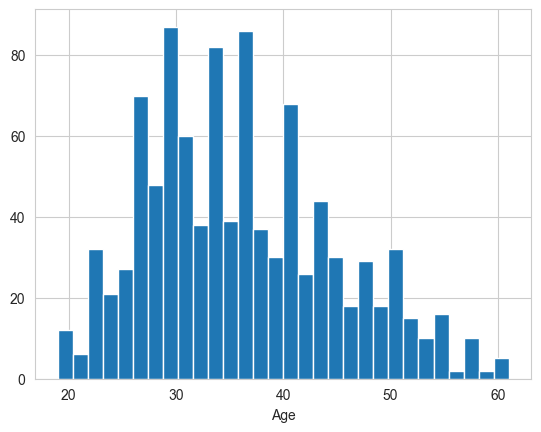

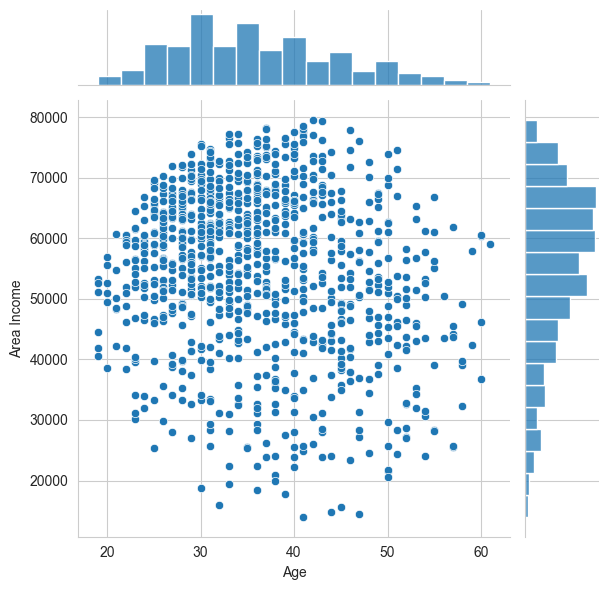

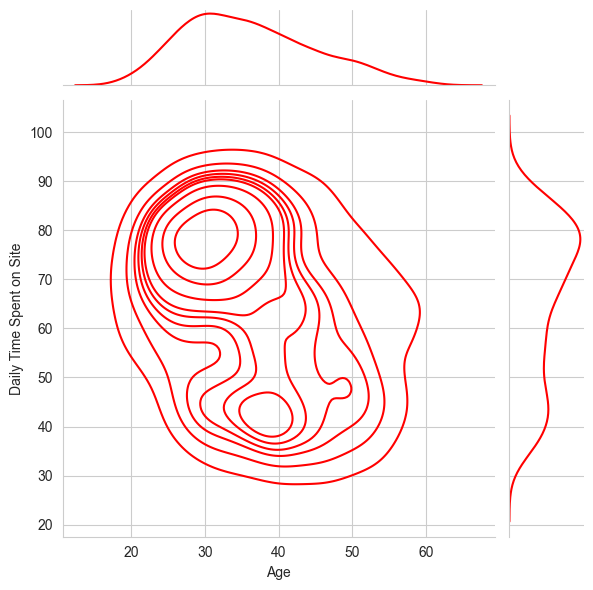

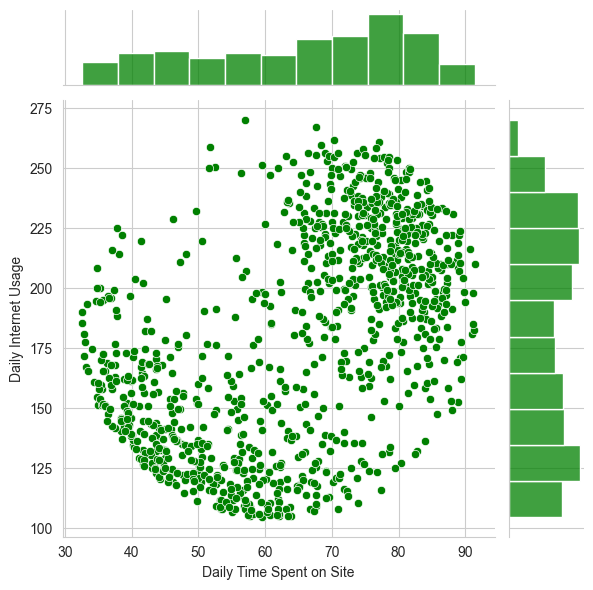

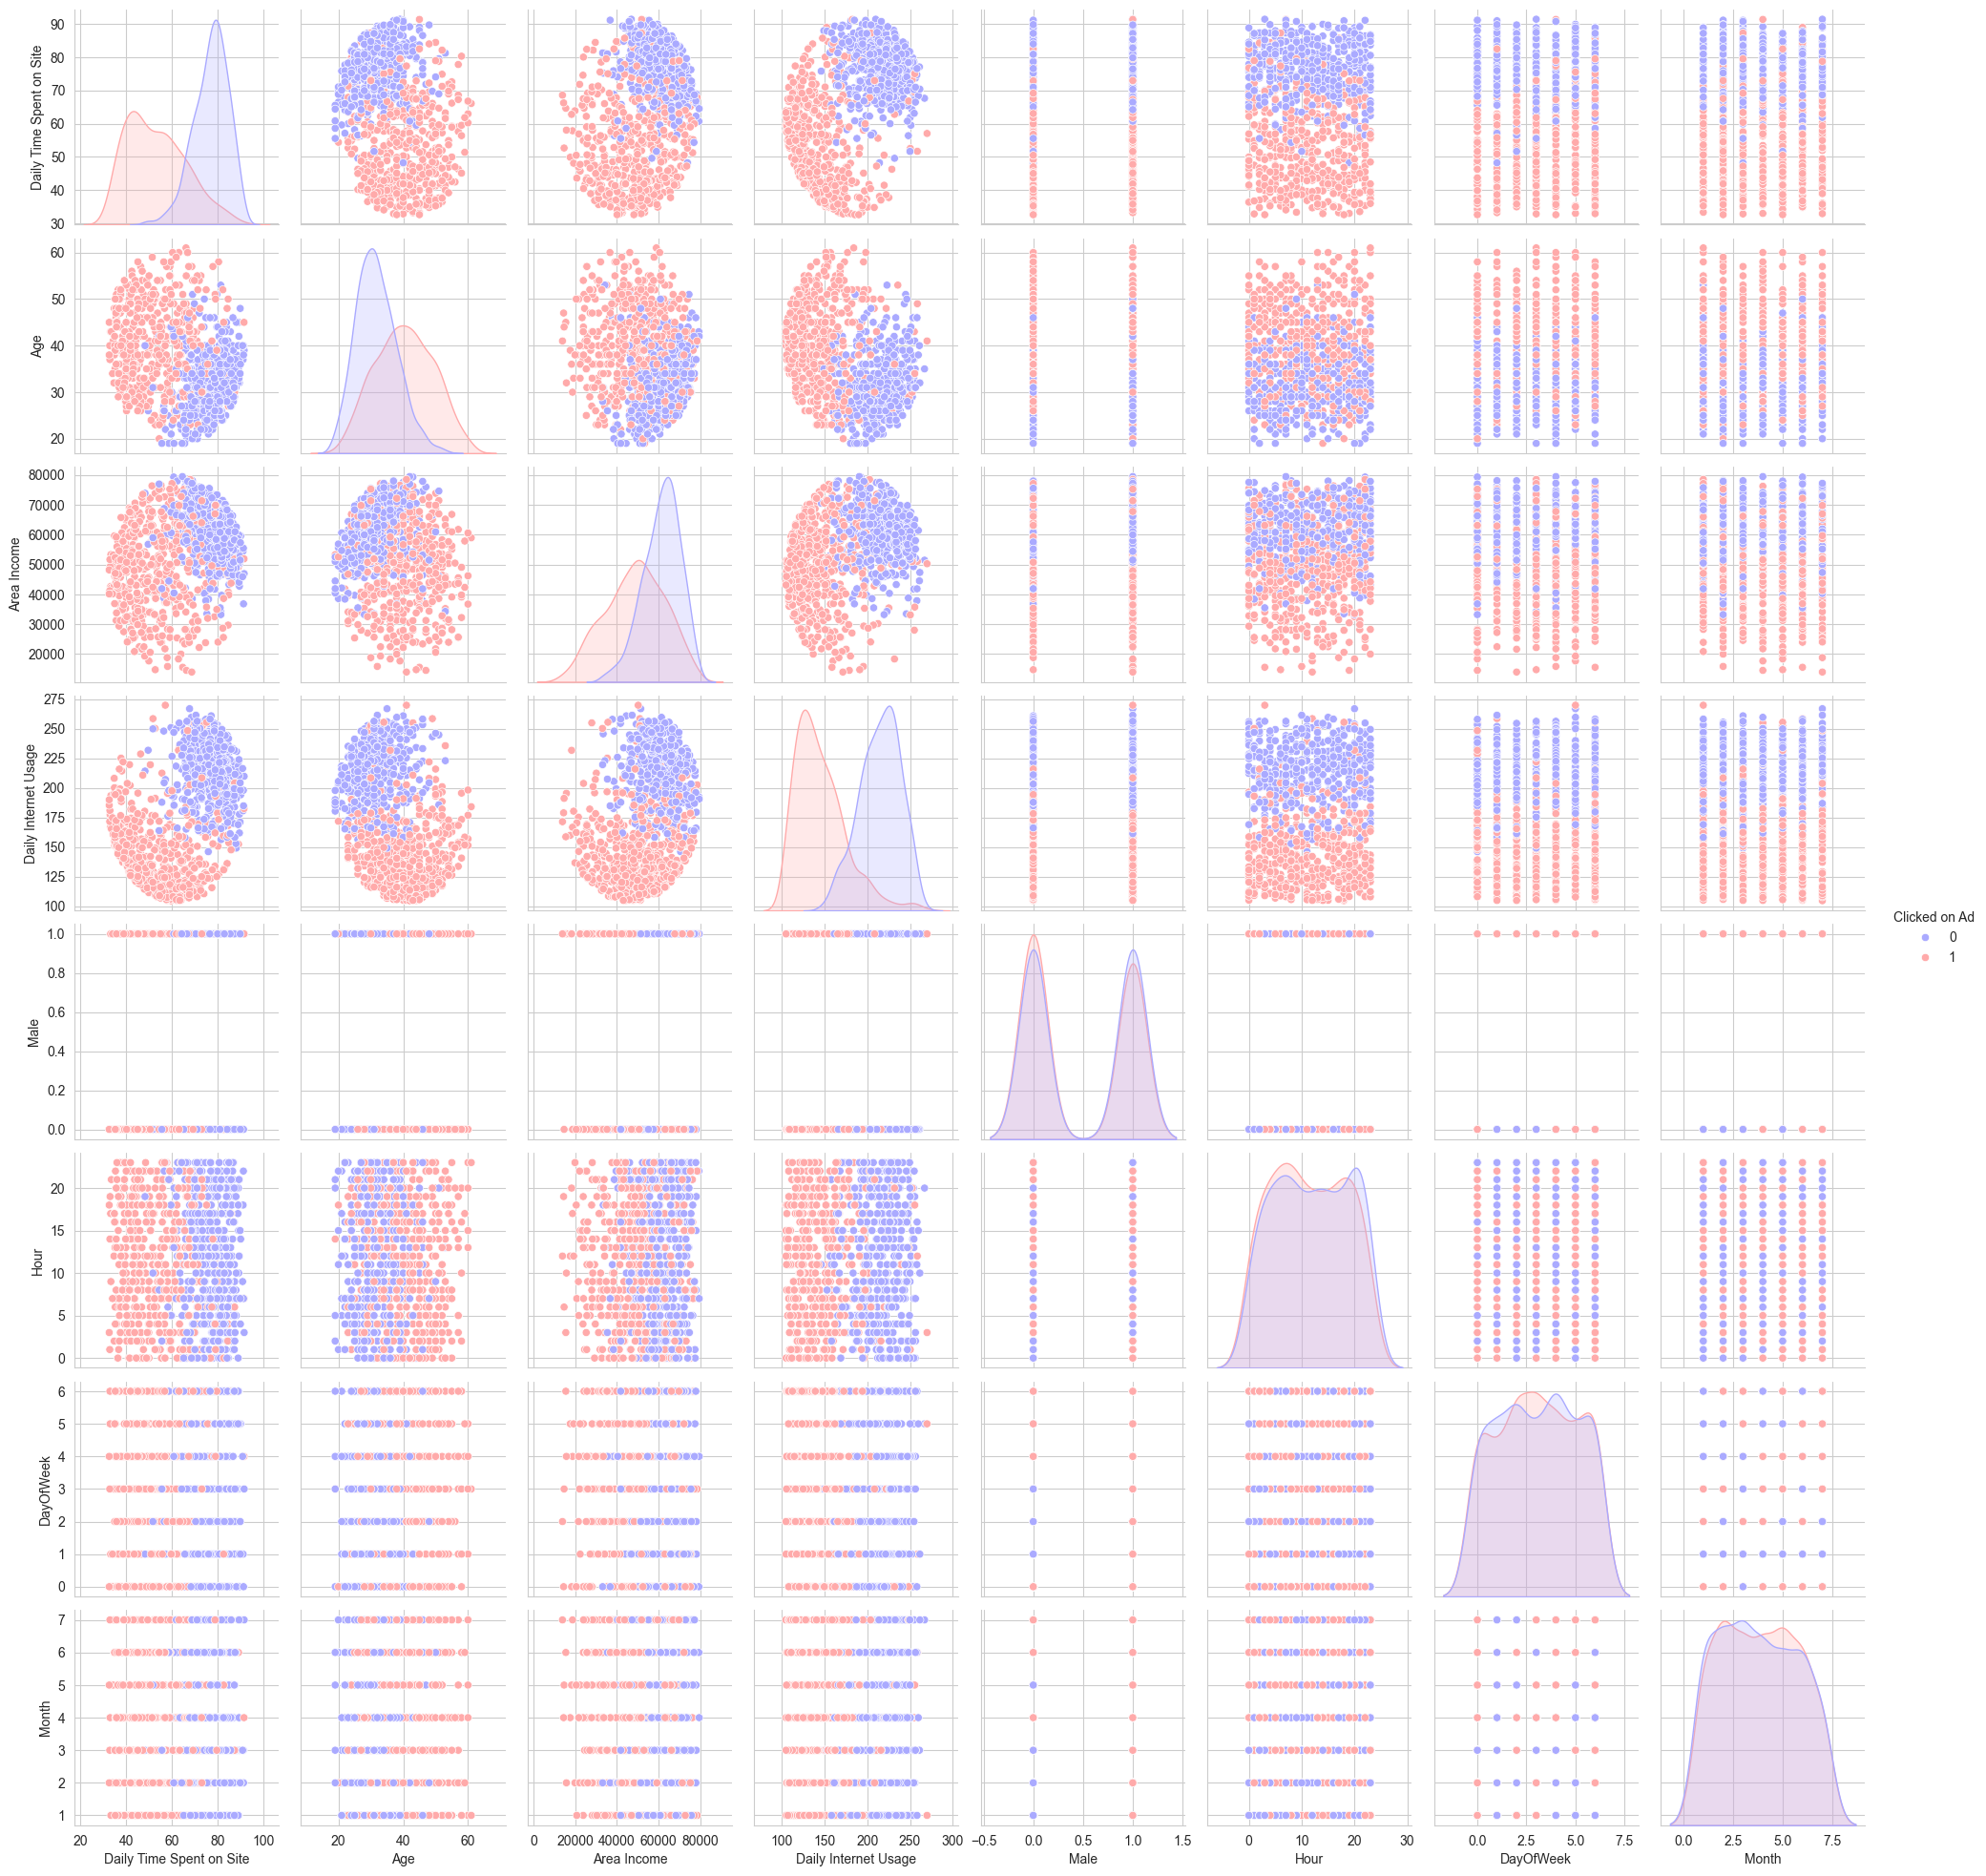

In [30]:
# Configurar o estilo dos gráficos
sns.set_style('whitegrid')

# Histograma da Idade
df['Age'].hist(bins=30)
plt.xlabel('Age')
plt.show()

# Jointplot de Area Income vs. Age
sns.jointplot(x='Age', y='Area Income', data=df)
plt.show()

# Jointplot de Daily Time Spent on Site vs. Age
sns.jointplot(x='Age', y='Daily Time Spent on Site', data=df, color='red', kind='kde')
plt.show()

# Jointplot de Daily Time Spent on Site vs. Daily Internet Usage
sns.jointplot(x='Daily Time Spent on Site', y='Daily Internet Usage', data=df, color='green')
plt.show()

# Pairplot com base na variável alvo
sns.pairplot(df, hue='Clicked on Ad', palette='bwr')
plt.show()

In [31]:
# Definir X (features) e y (variável alvo)
X = df.drop('Clicked on Ad', axis=1)
y = df['Clicked on Ad']

# Dividir os dados em conjuntos de treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=101)

In [32]:
# Criar e treinar o modelo de Regressão Logística
logmodel = LogisticRegression(solver='lbfgs', max_iter=500) # Adicionar max_iter para evitar warnings
logmodel.fit(X_train, y_train)

# Fazer previsões
predictions = logmodel.predict(X_test)

# Avaliar o modelo
print("Relatório de Classificação:")
print(classification_report(y_test, predictions))

print("\nMatriz de Confusão:")
print(confusion_matrix(y_test, predictions))

Relatório de Classificação:
              precision    recall  f1-score   support

           0       0.95      0.98      0.97       157
           1       0.98      0.94      0.96       143

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300


Matriz de Confusão:
[[154   3]
 [  8 135]]


c:\Users\vini\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:473: ConvergenceWarning: lbfgs failed to converge after 500 iteration(s) (status=1):
STOP: TOTAL NO. OF ITERATIONS REACHED LIMIT

Increase the number of iterations to improve the convergence (max_iter=500).
You might also want to scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(



Gerando gráfico de impacto das features com SHAP:


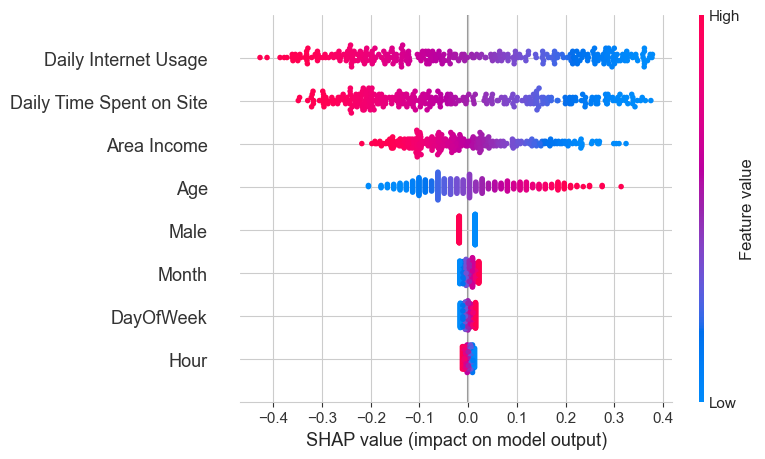

In [34]:

# 1. Extrair os componentes treinados do nosso pipeline final ('best_model')
# 'best_model' é o resultado do seu GridSearchCV e contém o scaler e o modelo já treinados.
scaler = best_model.named_steps['scaler']
logreg_model = best_model.named_steps['logreg']

# 2. Aplicar a padronização (que estava dentro do pipeline) aos nossos dados de teste
# O SHAP precisa que os dados estejam no mesmo formato que o modelo os recebeu para o treinamento.
X_test_scaled = scaler.transform(X_test)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_test.columns)

# 3. Criar o LinearExplainer
# Ele recebe o modelo final (logreg_model) e os dados de treinamento (também padronizados)
# para usar como referência de fundo.
explainer = shap.LinearExplainer(logreg_model, scaler.transform(X_train))

# 4. Calcular os valores SHAP para os dados de teste padronizados
shap_values = explainer.shap_values(X_test_scaled_df)

# 5. Gerar o gráfico de resumo (summary_plot)
print("\nGerando gráfico de impacto das features com SHAP:")
shap.summary_plot(shap_values, X_test_scaled_df)

---
## Parte 2: Benchmarking com Outros Modelos

Agora que temos um modelo de Regressão Logística otimizado e bem compreendido, vamos compará-lo com outros algoritmos de classificação poderosos para ver se conseguimos uma performance ainda melhor.

In [35]:
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, accuracy_score

# --- Dicionário para armazenar os resultados para comparação ---
results = {}

# Guardar os resultados do nosso melhor modelo de Regressão Logística
# Nota: 'best_model' é o pipeline otimizado do GridSearchCV
y_pred_logreg = best_model.predict(X_test)
results['Logistic Regression'] = {
    'AUC': roc_auc_score(y_test, best_model.predict_proba(X_test)[:, 1]),
    'Accuracy': accuracy_score(y_test, y_pred_logreg)
}

print("Iniciando o benchmark...")
print(f"Resultado do Baseline (Regressão Logística): {results['Logistic Regression']}")

# --- Modelo 2: Random Forest ---
print("\nTreinando o modelo Random Forest...")

# Criamos um pipeline igual ao anterior para garantir uma comparação justa
pipeline_rf = Pipeline([
    ('scaler', StandardScaler()),
    ('rf', RandomForestClassifier(n_estimators=100, random_state=101, n_jobs=-1))
])

pipeline_rf.fit(X_train, y_train)
y_pred_rf = pipeline_rf.predict(X_test)

results['Random Forest'] = {
    'AUC': roc_auc_score(y_test, pipeline_rf.predict_proba(X_test)[:, 1]),
    'Accuracy': accuracy_score(y_test, y_pred_rf)
}
print(f"Resultado do Random Forest: {results['Random Forest']}")
print("\nRelatório de Classificação - Random Forest:")
print(classification_report(y_test, y_pred_rf))


# --- Modelo 3: XGBoost ---
print("\nTreinando o modelo XGBoost...")

pipeline_xgb = Pipeline([
    ('scaler', StandardScaler()),
    ('xgb', XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=101))
])

pipeline_xgb.fit(X_train, y_train)
y_pred_xgb = pipeline_xgb.predict(X_test)

results['XGBoost'] = {
    'AUC': roc_auc_score(y_test, pipeline_xgb.predict_proba(X_test)[:, 1]),
    'Accuracy': accuracy_score(y_test, y_pred_xgb)
}
print(f"Resultado do XGBoost: {results['XGBoost']}")
print("\nRelatório de Classificação - XGBoost:")
print(classification_report(y_test, y_pred_xgb))


# --- Comparação Final ---
print("\n--- Tabela de Comparação de Resultados ---")
results_df = pd.DataFrame(results).T
results_df = results_df.sort_values(by='AUC', ascending=False)
print(results_df)

Iniciando o benchmark...
Resultado do Baseline (Regressão Logística): {'AUC': 0.9980401763841255, 'Accuracy': 0.9733333333333334}

Treinando o modelo Random Forest...
Resultado do Random Forest: {'AUC': 0.9946995679479755, 'Accuracy': 0.9566666666666667}

Relatório de Classificação - Random Forest:
              precision    recall  f1-score   support

           0       0.95      0.97      0.96       157
           1       0.96      0.94      0.95       143

    accuracy                           0.96       300
   macro avg       0.96      0.96      0.96       300
weighted avg       0.96      0.96      0.96       300


Treinando o modelo XGBoost...
Resultado do XGBoost: {'AUC': 0.9882410583047526, 'Accuracy': 0.9466666666666667}

Relatório de Classificação - XGBoost:
              precision    recall  f1-score   support

           0       0.95      0.95      0.95       157
           1       0.94      0.94      0.94       143

    accuracy                           0.95       300
   

c:\Users\vini\AppData\Local\Programs\Python\Python313\Lib\site-packages\xgboost\training.py:183: UserWarning: [22:34:58] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)
